# Problem 8:  Flow cytometry

The method of flow cytometry is a rapid and cost-effective method to study large samples of cells.
Every cell is measured for multiple quantities. 

There are two possible objectives:
One is to observe a sample of cells, and determine what the groupings are. 
This is outside our current assignment. 
Methods including "k-means" can be used for this.

The other possible objective is to develop a predictive model.
Suppose you have a training set of cells where you know the cells are one of two types -- say, activate and inactive immune cells.
You observe a new cell, not from the training set. 
Is it active or not?
For this question, we will use the method of __k-nearest-neighbors__.

We will first use synthetic data (where we can measure true accuracy) and then real data.

The following code generates synthetic  FACS data:

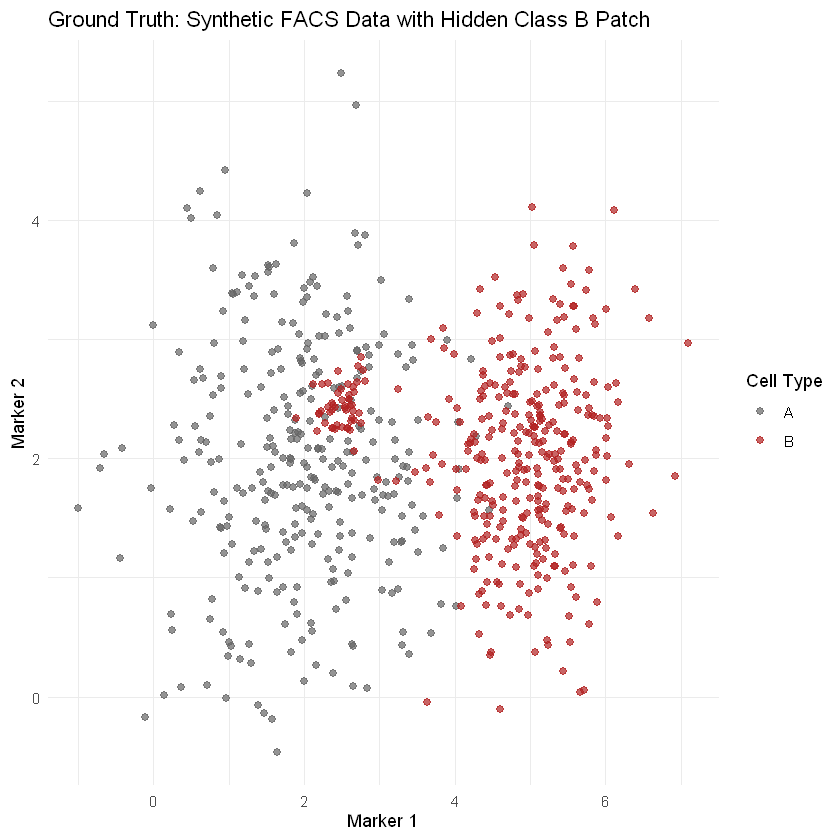

In [1]:
# Load required packages
library(ggplot2)
library(class)  # for knn
set.seed(42)

# === Function to Generate Synthetic FACS Data ===
generate_facs_data <- function(n = 350) {
  # Class A: Large Gaussian cloud
  classA <- data.frame(
    Marker1 = rnorm(n - 40, mean = 2, sd = 1.0),
    Marker2 = rnorm(n - 40, mean = 2, sd = 1.0),
    Label = factor(rep("A", n - 40))
  )
  
  # Class B1: Tiny tight cluster inside A
  classB1 <- data.frame(
    Marker1 = rnorm(50, mean = 2.5, sd = 0.2),
    Marker2 = rnorm(50, mean = 2.5, sd = 0.2),
    Label = factor(rep("B", 50))
  )

  # Class B2:
  classB2 <- data.frame(
    Marker1 = rnorm(n - 40, mean = 5.0, sd = 0.6),
    Marker2 = rnorm(n - 40, mean = 2, sd = 0.8),
    Label = factor(rep("B", n - 40))
  )
  
  rbind(classA, classB1, classB2)

}

# Generate and plot a fresh dataset
data <- generate_facs_data()

ggplot(data, aes(x = Marker1, y = Marker2, color = Label)) +
  geom_point(size = 2, alpha = 0.7) +
  scale_color_manual(values = c("A" = "gray40", "B" = "firebrick")) +
  theme_minimal() +
  labs(title = "Ground Truth: Synthetic FACS Data with Hidden Class B Patch",
       x = "Marker 1", y = "Marker 2", color = "Cell Type")  

## Question i

Generate two data sets.
For now, choose `k = 10`.
Use the first to train the knn model with `k = 10`, and make predictions fo the 2nd dataset.

Define the __accuracy__ as the number of correctly-classified cells divided by the total number of cells.
Compute the accuracy.

In [35]:
set.seed(42)
k <- 10
training_data <- generate_facs_data()
testing_data <- generate_facs_data()
pred <- knn(training_data[,1:2], testing_data[,1:2], cl = training_data$Label, k = k)
acc <- mean(pred == testing_data$Label)

cat("Accuracy with k =", k, ":", acc, "\n")

Accuracy with k = 10 : 0.9432836 


## Question ii

Read about the [k-nearest-neighbors model](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) on wikipedia or elsewhere. 
In words, what is the meaning of $k$?

Inspect the data.
What value of $k$ do you think will maximize accuracy?

# Answer ii

- The k-NN model is a classifier that assigns a class to a new data point not used in training. The way it assigns the class is by looking at classes of the $k$ nearest neighbors, and simply be assigning the class that makes up the majority.
- 

## Question iii

Perform a sweep over k values 1 to 60, `k_values <- 1:60`, repeating the above accuracy calculation.
Plot accuracy versus k. 
What is the k that maximizes accuracy?

Optimal k based on iterations: 16 


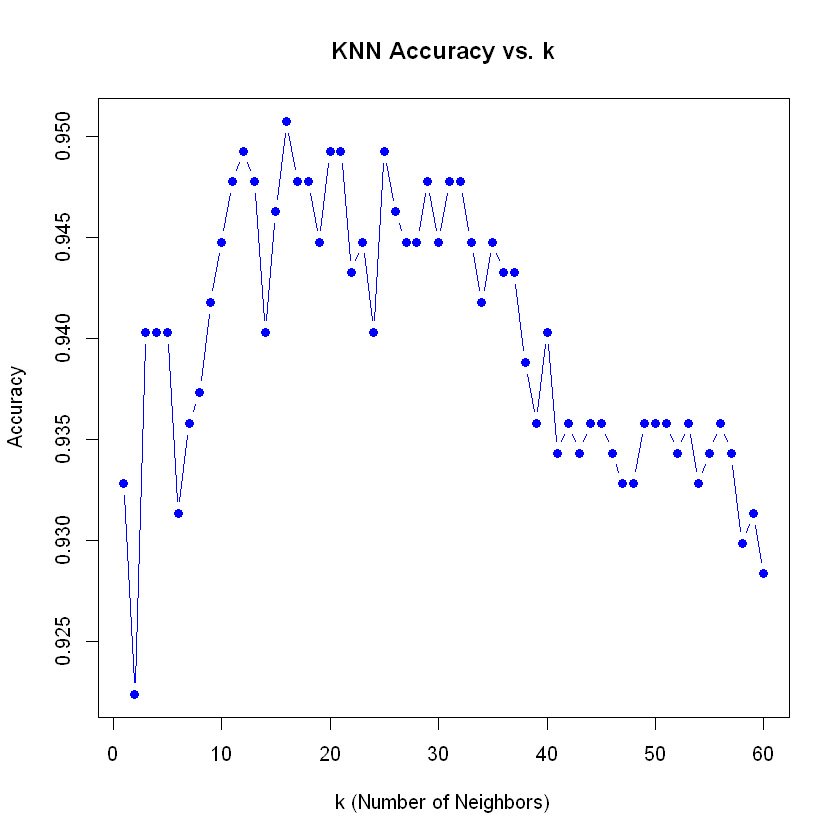

In [38]:
# CODE HERE
# Load required library
set.seed(42)
library(class)

# Generate training and testing data
training_data <- generate_facs_data()
testing_data <- generate_facs_data()

# Initialize a vector to store accuracies
max_value_k <- 60
accuracies <- numeric(max_value_k)

# Loop over k from 1 to 60
for (k in 1:max_value_k) {
  pred <- knn(training_data[, 1:2], testing_data[, 1:2], cl = training_data$Label, k = k)
  acc <- mean(pred == testing_data$Label)
  accuracies[k] <- acc
}

# Plot accuracy vs. k
par(bg = "white")
plot(1:max_value_k, accuracies, type = "b", pch = 19, col = "blue",
     xlab = "k (Number of Neighbors)", ylab = "Accuracy",
     main = "KNN Accuracy vs. k")

# Find optimal k
optimal_k <- which.max(accuracies)
cat("Optimal k based on iterations:", optimal_k, "\n")

## Question iii

In this part, assume you do not have the ability to generate a 2nd dataset.
This is much more realistic, since if you have the 2nd dataset, you would simply use it to train the model.

Use cross-validation to determine the $k$ that maximizes accuracy.
How does the optimal $k$ compare to the one you found in the previous part?
You may use 10-fold cross-validation or leave-one-out cross-validation.

# Look into knn.cv 

Loading required package: lattice



Optimal k based on 10 -fold CV: 13 


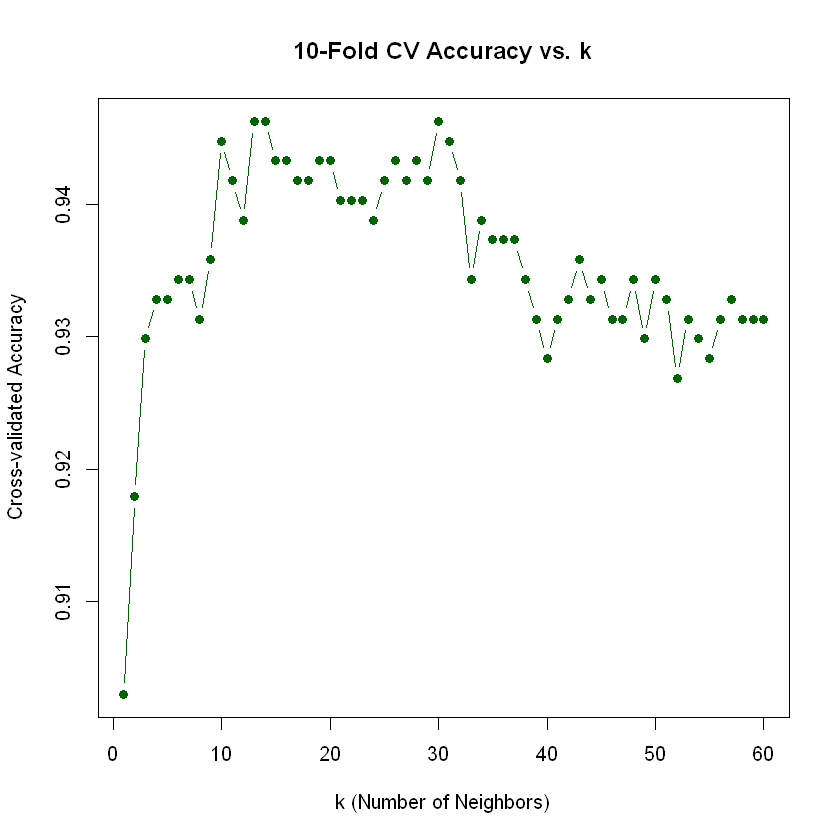

In [39]:
# CODE HERE
library(class)
library(caret)  # For creating folds

# Generate one dataset
set.seed(42)
data <- generate_facs_data()

# Set up cross-validation folds
num_folds <- 10
folds <- createFolds(data$Label, k = num_folds, list = TRUE)

# Initialize accuracy vector
max_value_k <- 60
accuracies <- numeric(max_value_k)

# Loop over k = 1 to 60
for (k in 1:max_value_k) {
  fold_accuracies <- numeric(num_folds)
  
  for (i in 1:num_folds) {
    test_indices <- folds[[i]]
    train_data <- data[-test_indices, ]
    test_data <- data[test_indices, ]
    
    pred <- knn(train_data[,1:2], test_data[,1:2],
                cl = train_data$Label, k = k)
    
    fold_accuracies[i] <- mean(pred == test_data$Label)
  }
  
  accuracies[k] <- mean(fold_accuracies)
}

# Plot accuracy vs. k
par(bg = "white")
plot(1:max_value_k, accuracies, type = "b", pch = 19, col = "darkgreen",
     xlab = "k (Number of Neighbors)", ylab = "Cross-validated Accuracy",
     main = "10-Fold CV Accuracy vs. k")

# Find optimal k
optimal_k <- which.max(accuracies)
cat("Optimal k based on", num_folds, "-fold CV:", optimal_k, "\n")

Optimal k using LOOCV: 19 


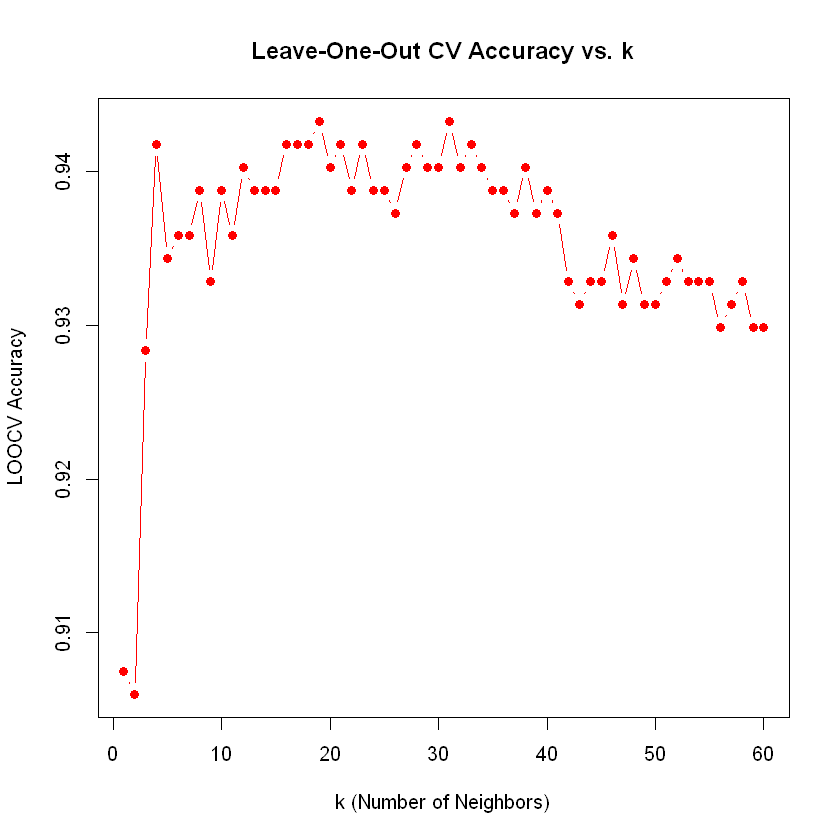

In [40]:
set.seed(42)
data <- generate_facs_data()
n <- nrow(data)
max_value_k <- 60
accuracies <- numeric(max_value_k)
for (k in 1:max_value_k) {
  correct <- 0
  
  for (i in 1:n) {
    train_data <- data[-i, ]
    test_data <- data[i, , drop = FALSE]
    
    pred <- knn(train_data[,1:2], test_data[,1:2],
                cl = train_data$Label, k = k)
    
    if (pred == test_data$Label) {
      correct <- correct + 1
    }
  }
  
  accuracies[k] <- correct / n
}

# Plot
par(bg="white")
plot(1:max_value_k, accuracies, type = "b", pch = 19, col = "red",
     xlab = "k (Number of Neighbors)", ylab = "LOOCV Accuracy",
     main = "Leave-One-Out CV Accuracy vs. k")

optimal_k <- which.max(accuracies)
cat("Optimal k using LOOCV:", optimal_k, "\n")

Optimal k using LOOCV with knn.cv(): 19 


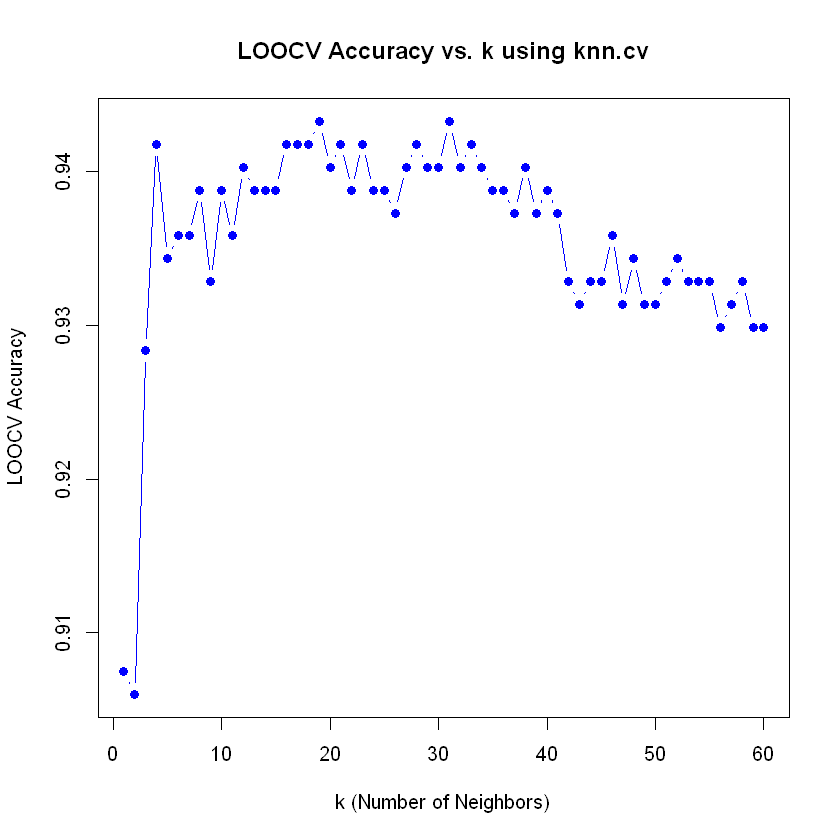

In [41]:
# Generate data
set.seed(42)
data <- generate_facs_data()

# Extract features and labels
features <- data[, 1:2]
labels <- data$Label

# Initialize
max_value_k <- 60
accuracies <- numeric(max_value_k)

# Loop over k
for (k in 1:max_value_k) {
  preds <- knn.cv(train = features, cl = labels, k = k)
  accuracies[k] <- mean(preds == labels)
}

# Plot
par(bg = "white")
plot(1:max_value_k, accuracies, type = "b", pch = 19, col = "blue",
     xlab = "k (Number of Neighbors)", ylab = "LOOCV Accuracy",
     main = "LOOCV Accuracy vs. k using knn.cv")

# Find optimal k
optimal_k <- which.max(accuracies)
cat("Optimal k using LOOCV with knn.cv():", optimal_k, "\n")
